In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import logging as log

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig
from transformers import AdamW

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, trange
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, classification_report

SEED = 17

In [2]:
log.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    filename='xlnet_multilabel.log',
                    level=log.INFO)
logger = log.getLogger(__name__)

#### Setting up gpu environment

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

Preparing NYT dataset for *XLNet*


In [4]:
#from google.colab import auth
import pandas as pd
#auth.authenticate_user()
df_full = pd.read_parquet('../data/nyt.2000.parquet.gz')

In [5]:
df_full.shape

(32146, 14)

In [6]:
# sample a small set of observations for testing 
#df = df_full.sample(10000, random_state=SEED)

# full dataset for the real deal
df = df_full

df = df.set_index("Id")

In [7]:
df[df.Health == 1].head()

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology
Id,,,,,,,,,,,,,
1165059,The man accused of stabbing George Harrison on...,1,0,0,0,0,0,0,0,1,0,0,0
1165110,"Most nights, P. J. Sanchez, 9, comes into his ...",0,0,1,0,0,0,0,0,1,0,0,0
1165173,"Of all the instincts in animals, the strongest...",0,0,0,0,0,0,0,0,1,0,0,0
1165189,"THE Scarecrow in ""The Wizard of Oz"" wanted onl...",0,0,0,0,0,0,0,0,1,0,0,0
1165219,"UNLIKE the sheep named Dolly, the mouse named ...",0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

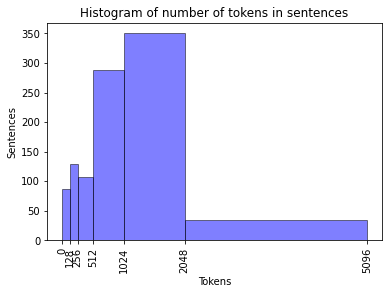

In [9]:
plt.hist(
    [len(s) for s in df.sample(1000)["Text"].apply(lambda x: tokenizer.tokenize(x))], 
    bins=[0, 128, 256, 512, 1024, 2048, 5096], 
    histtype='bar', 
    facecolor='b',
    edgecolor='k',
    alpha=0.5)
plt.xticks([0, 128, 256, 512, 1024, 2048, 5096], rotation='vertical')
plt.xlabel('Tokens')
plt.ylabel('Sentences')
plt.title('Histogram of number of tokens in sentences')
plt.show()

In [10]:
# Sentences larger than MAX_LEN are truncated (out-of-memory workaround)
MAX_LEN = 128

df_input_ids_full = df["Text"].copy()
XLNET_END_TOKEN_IDS = tokenizer.encode("[SEP][CLS]")

for i in tqdm(df_input_ids_full.index, desc="Tokenizer"):
    input_ids = tokenizer.convert_tokens_to_ids(
        tokenizer.tokenize(df_input_ids_full[i])[:MAX_LEN - len(XLNET_END_TOKEN_IDS)])
    df_input_ids_full.at[i] = input_ids + XLNET_END_TOKEN_IDS

df_input_ids_full.shape
# the code below causes out-of-memory crash and the code above was used

# convert to XLNet vocabulary tokens
df["tokens"] = df["Text"].apply(lambda x: tokenizer.tokenize(x + " [SEP] [CLS]"))

# convert tokens to XLNet vocabulary ids
df["input_ids_full"] = df["tokens"].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

Tokenizer: 100%|██████████| 32146/32146 [01:10<00:00, 453.69it/s]


In [11]:
# using Keras function to handle padding
df["input_ids"] = pad_sequences(
    df_input_ids_full, 
    maxlen=MAX_LEN, 
    dtype="long", 
    padding="post", 
    value=0).tolist()

# Create XLNet masks: 1 for tokens 0 for padding
attention_masks = []
for input_id in df.input_ids:
    mask = [int(i>0) for i in input_id]
    attention_masks.append(mask)
df["attention_masks"] = attention_masks

# Create XLNet segments: 0 for each token of the first sentence, 
# followed by a 1 for each token of the second sentence.  For one sentence 
# inputs, this is simply a sequence of 0s
df["segment_masks"] = np.zeros((df.shape[0], MAX_LEN), dtype=int).tolist()

In [12]:
# check for a observation with less than MAX_LEN tokens
for i in df.index:
    if(np.count_nonzero(df.loc[i, "input_ids"]) < 128):
        print("Index:", i)
        print(df.loc[i, "Text"])
        print(df.loc[i, "input_ids"])
        print(np.count_nonzero(df.loc[i, "input_ids"]))
        print(df.loc[i, "attention_masks"])
        print(np.count_nonzero(df.loc[i, "attention_masks"]))
        print(df.loc[i, "segment_masks"])
        print(np.count_nonzero(df.loc[i, "segment_masks"]))
        break


Index: 1165119
The hijackers of an Indian Airlines plane won the release of three prominent militants jailed in India. All of them sped away from the airport in Afghanistan, trying to get out of the country. The names and nationalities of the hijackers are still unknown. With the release, more than 150 haggard passengers, kept on board for eight days, were freed unharmed. They flew to New Delhi, for family reunions, both wrenching and joyous.
[32, 24362, 20, 48, 1280, 6227, 2352, 282, 18, 947, 20, 139, 3788, 3211, 11733, 25, 837, 9, 394, 20, 107, 24646, 308, 40, 18, 2212, 25, 1805, 19, 619, 22, 133, 78, 20, 18, 234, 9, 32, 1931, 21, 27321, 20, 18, 24362, 41, 194, 4027, 9, 473, 18, 947, 19, 70, 100, 4076, 10118, 299, 11992, 3372, 19, 1340, 31, 1036, 28, 869, 307, 19, 55, 8494, 28510, 9, 200, 5415, 22, 158, 6849, 19, 28, 273, 15459, 23, 19, 207, 17, 29741, 21, 30584, 9, 4145, 83, 8186, 3158, 10849, 7416, 83, 3158, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
df.sample(5)

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology,tokens,input_ids_full,input_ids,attention_masks,segment_masks
Id,,,,,,,,,,,,,,,,,,
1215492,The Yankees called their temp agency -- Class ...,0,0,0,0,0,0,1,0,0,0,0,0,"[▁The, ▁Yankees, ▁called, ▁their, ▁temp, ▁agen...","[32, 6445, 271, 58, 16080, 1100, 17, 13, 13, 5...","[32, 6445, 271, 58, 16080, 1100, 17, 13, 13, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1194582,"To the Editor:\nAs a psychiatrist, I am appall...",0,0,0,0,0,0,0,0,0,0,1,0,"[▁To, ▁the, ▁Editor, :, ▁As, ▁a, ▁psychiatrist...","[324, 18, 10955, 60, 228, 24, 18437, 19, 35, 5...","[324, 18, 10955, 60, 228, 24, 18437, 19, 35, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1233574,"In the Olympics, there is the quaint notion th...",0,0,0,0,0,0,1,0,0,0,0,0,"[▁In, ▁the, ▁Olympics, ,, ▁there, ▁is, ▁the, ▁...","[67, 18, 2807, 19, 105, 27, 18, 28657, 7097, 2...","[67, 18, 2807, 19, 105, 27, 18, 28657, 7097, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1252507,DEAR DIARY:\nOutside Our Lady of Mercy Medical...,0,0,1,0,0,0,0,0,0,0,0,0,"[▁D, EAR, ▁DI, ARY, :, ▁Outside, ▁Our, ▁Lady, ...","[347, 15026, 17711, 25700, 60, 12468, 1146, 51...","[347, 15026, 17711, 25700, 60, 12468, 1146, 51...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1166829,"Don Martin, the Mad magazine cartoonist with a...",0,0,0,0,0,0,0,1,0,0,0,0,"[▁Don, ▁Martin, ,, ▁the, ▁Mad, ▁magazine, ▁car...","[1609, 1868, 19, 18, 5171, 2140, 28682, 33, 24...","[1609, 1868, 19, 18, 5171, 2140, 28682, 33, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
import os

MODEL_PATH = "../xlnet"

In [15]:
xlnet_ds_prepared = MODEL_PATH + "/xlnet_prepared_ds_parquet.gzip"
df.to_parquet(xlnet_ds_prepared, compression='gzip')
df = pd.read_parquet(xlnet_ds_prepared)
#df = df.sample(50000, random_state = SEED)

#### Split training and test sets

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state = SEED)

print(train_df.shape, test_df.shape)

(25716, 18) (6430, 18)


#### Put data into data loader

In [17]:
tt_train_input_ids = torch.tensor(train_df["input_ids"].tolist())
tt_test_input_ids = torch.tensor(test_df["input_ids"].tolist())

tt_train_attention_masks = torch.tensor(train_df["attention_masks"].tolist())
tt_test_attention_masks = torch.tensor(test_df["attention_masks"].tolist())

tt_train_segment_masks = torch.tensor(train_df["segment_masks"].tolist())
tt_test_segment_masks = torch.tensor(test_df["segment_masks"].tolist())

label_columns = [
  'World',
  'Washington',
  'New_York_and_Region',
  'Front_Page',
  'Business',
  'US',
  'Sports',
  'Obituaries',
  'Health',
  'Education',
  'Science',
  'Technology']

tt_train_labels = torch.tensor(train_df[label_columns].values.astype(np.float))
tt_test_labels = torch.tensor(test_df[label_columns].values.astype(np.float))

In [18]:
# training batch size
batch_num = 32

train_data = TensorDataset(
    tt_train_input_ids, 
    tt_train_attention_masks, 
    tt_train_segment_masks, 
    tt_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(
    tt_test_input_ids, 
    tt_test_attention_masks, 
    tt_test_segment_masks, 
    tt_test_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=batch_num, drop_last=False, shuffle=False)

#### Custom

In [19]:
from transformers import XLNetPreTrainedModel
from torch.nn import BCEWithLogitsLoss, Identity

"""Copied from transformers package (modeling_utils.py) for dependencies
  resolution. """
class SequenceSummary(torch.nn.Module):
    
    def __init__(self, config):
        super(SequenceSummary, self).__init__()

        self.summary_type = config.summary_type if hasattr(config, 'summary_use_proj') else 'last'
        if self.summary_type == 'attn':
            raise NotImplementedError

        self.summary = Identity()
        if hasattr(config, 'summary_use_proj') and config.summary_use_proj:
            if hasattr(config, 'summary_proj_to_labels') and config.summary_proj_to_labels and config.num_labels > 0:
                num_classes = config.num_labels
            else:
                num_classes = config.hidden_size
            self.summary = torch.nn.Linear(config.hidden_size, num_classes)

        self.activation = Identity()
        if hasattr(config, 'summary_activation') and config.summary_activation == 'tanh':
            self.activation = torch.nn.Tanh()

        self.first_dropout = Identity()
        if hasattr(config, 'summary_first_dropout') and config.summary_first_dropout > 0:
            self.first_dropout = torch.nn.Dropout(config.summary_first_dropout)

        self.last_dropout = Identity()
        if hasattr(config, 'summary_last_dropout') and config.summary_last_dropout > 0:
            self.last_dropout = torch.nn.Dropout(config.summary_last_dropout)

    def forward(self, hidden_states, cls_index=None):
        """ hidden_states: float Tensor in shape [bsz, ..., seq_len, hidden_size], the hidden-states of the last layer.
            cls_index: [optional] position of the classification token if summary_type == 'cls_index',
                shape (bsz,) or more generally (bsz, ...) where ... are optional leading dimensions of hidden_states.
                if summary_type == 'cls_index' and cls_index is None:
                    we take the last token of the sequence as classification token
        """
        if self.summary_type == 'last':
            output = hidden_states[:, -1]
        elif self.summary_type == 'first':
            output = hidden_states[:, 0]
        elif self.summary_type == 'mean':
            output = hidden_states.mean(dim=1)
        elif self.summary_type == 'cls_index':
            if cls_index is None:
                cls_index = torch.full_like(hidden_states[..., :1, :], hidden_states.shape[-2]-1, dtype=torch.long)
            else:
                cls_index = cls_index.unsqueeze(-1).unsqueeze(-1)
                cls_index = cls_index.expand((-1,) * (cls_index.dim()-1) + (hidden_states.size(-1),))
            # shape of cls_index: (bsz, XX, 1, hidden_size) where XX are optional leading dim of hidden_states
            output = hidden_states.gather(-2, cls_index).squeeze(-2) # shape (bsz, XX, hidden_size)
        elif self.summary_type == 'attn':
            raise NotImplementedError

        output = self.first_dropout(output)
        output = self.summary(output)
        output = self.activation(output)
        output = self.last_dropout(output)

        return output

In [20]:
"""Alters the XLNetForSequenceClassification from HuggingFace to cater 
   for multiclass multilabel classification . """
class XLNetForMultilabelSequenceClassification(XLNetPreTrainedModel):
    
    def __init__(self, config):
        super(XLNetForMultilabelSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.transformer = XLNetModel(config)
        self.sequence_summary = SequenceSummary(config)
        self.logits_proj = torch.nn.Linear(config.d_model, config.num_labels)

        self.init_weights()

    def forward(self, 
                input_ids, 
                attention_mask=None, 
                mems=None, 
                perm_mask=None, 
                target_mapping=None,
                token_type_ids=None, 
                input_mask=None, 
                head_mask=None, 
                labels=None):
      
        transformer_outputs = self.transformer(input_ids,
                                               attention_mask=attention_mask,
                                               mems=mems,
                                               perm_mask=perm_mask,
                                               target_mapping=target_mapping,
                                               token_type_ids=token_type_ids,
                                               input_mask=input_mask,
                                               head_mask=head_mask)
        output = transformer_outputs[0]

        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        outputs = (logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                #  We multilabel multiclass
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            outputs = (loss,) + outputs

        return outputs  # return (loss), logits, (mems), (hidden states), (attentions)

#### Load XLNet model

In [21]:
model = XLNetForMultilabelSequenceClassification.from_pretrained(
    'xlnet-base-cased', num_labels=len(label_columns))
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultilabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultilabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

XLNetForMultilabelSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768

In [22]:
# Set epoch and grad max num
epochs = 2
max_grad_norm = 1.0

In [23]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)

#### Fine-tuning the XLNet model

In [24]:
model.train();

In [25]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tt_train_input_ids)))
print("  Batch size = %d"%(batch_num))

model_save_name = MODEL_PATH + "/pytorch_model.bin"
model_config_save_name = MODEL_PATH + "/config.json"
model_report_save_name = MODEL_PATH + "/multilabel_eval_results.txt"

def delete_existing(filename):
    if os.path.exists(filename):
        os.remove(filename)    

for epoch in trange(epochs,desc="Epoch"):
    logger.info(f'Starting epoch {epoch}')
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        logger.info(f'Starting step {step}')
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs, b_labels = batch
        
        # forward pass
        outputs = model(
            input_ids = b_input_ids, 
            token_type_ids = b_segs, 
            input_mask = b_input_mask,
            labels= b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("Saving the results for the epoch")
    logger.info("Train loss: {}".format(tr_loss/nb_tr_steps))
    logger.info("Saving the results for the epoch")
    
    delete_existing(model_save_name)
    torch.save(model.state_dict(), model_save_name)
    delete_existing(model_config_save_name)
    model.config.to_json_file(model_config_save_name)


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 25716
  Batch size = 32
Train loss: 0.3191992768529116
Saving the results for the epoch


Epoch:  50%|█████     | 1/2 [23:07<23:07, 1387.80s/it]

Train loss: 0.31418117433064857
Saving the results for the epoch


Epoch: 100%|██████████| 2/2 [46:17<00:00, 1388.76s/it]


In [26]:
print(model_save_name)
print(model_config_save_name)

../xlnet/pytorch_model.bin
../xlnet/config.json


#### Saving the model

In [27]:
tokenizer.save_vocabulary(MODEL_PATH)

('../xlnet/spiece.model',)

#### Loading finetuned model

In [28]:
model = XLNetForMultilabelSequenceClassification.from_pretrained(
    MODEL_PATH, num_labels=len(label_columns))
model.cuda()

XLNetForMultilabelSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768

#### Model evaluation

In [29]:
root_folder = '../xlnet'

def load_model(folder=MODEL_PATH):
    model = XLNetForMultilabelSequenceClassification.from_pretrained(MODEL_PATH, num_labels=len(label_columns))
    
    if n_gpu != 0:
        model.cuda()
      
    return model

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)

def calculate_confusion_matrix(data_loader, model, batch_size):
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            #import pdb; pdb.set_trace()
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            #raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            raw_outputs = model(input_ids = b_input_ids, token_type_ids = b_segment_ids, input_mask = b_input_masks)
            predictions.append((torch.sigmoid(raw_outputs[0]) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(data_loader, model, batch_size):
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    skip_columns =  { 'Id', 'Text', 'input_ids', 'attention_masks', 'segment_masks', 'input_ids_full', 'tokens' }
    return [c for c in data_frame.columns if c not in skip_columns and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results

In [30]:
model = load_model()

In [31]:
model_results = ModelResult(test_df, valid_dataloader, model, 100)

In [32]:
model_results.save('xlnet_result_test.pkl')

In [33]:
model_results = load_object('xlnet_result_test.pkl')
model_results.label_columns = get_label_columns(test_df)

In [34]:
add_predictions_to_dataframe(test_df, model_results.predictions)

<ipython-input-29-9b913d7fef8b>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f'{column_name}_Pred'] = predictions[:, i]


In [35]:
test_df.shape

(6430, 30)

<AxesSubplot:ylabel='Frequency'>

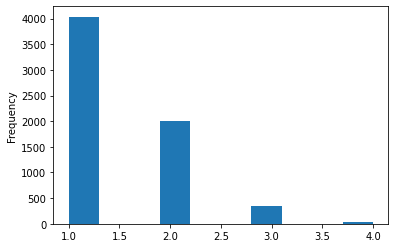

In [36]:
test_df[get_label_columns(test_df)].sum(1).plot.hist()

In [37]:
model_results.get_results_dataframe()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Label,Precision,Recall,F1-Score,Support
0,World,0.0,0.0,0.0,886
1,Washington,0.0,0.0,0.0,742
2,New_York_and_Region,0.0,0.0,0.0,1827
3,Front_Page,0.0,0.0,0.0,286
4,Business,0.0,0.0,0.0,859
5,US,0.0,0.0,0.0,1965
6,Sports,0.0,0.0,0.0,1694
7,Obituaries,0.0,0.0,0.0,271
8,Health,0.0,0.0,0.0,302
9,Education,0.0,0.0,0.0,78


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='Label'>

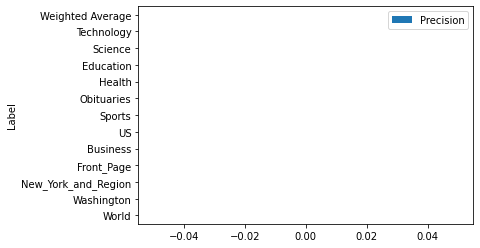

In [38]:
model_results.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

<AxesSubplot:ylabel='Frequency'>

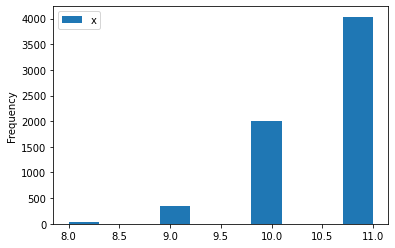

In [39]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

In [40]:
test_df[get_label_columns(test_df)].head(10)

,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology
Id,,,,,,,,,,,,
1237618,1,1,0,0,0,0,0,0,0,0,0,0
1226236,0,0,0,0,0,0,1,0,0,0,0,0
1191961,0,0,0,0,1,0,0,0,0,0,0,0
1177939,0,0,1,0,0,0,0,0,0,0,0,0
1252037,0,0,1,0,0,1,0,0,0,0,0,0
1196576,0,0,0,0,1,0,0,0,0,0,0,0
1245333,0,0,1,0,0,1,0,0,0,0,0,0
1205239,0,0,0,0,1,0,0,0,0,0,0,0
1234701,0,0,1,0,0,0,0,0,0,0,0,0


In [41]:
test_df[[f'{c}_Pred' for c in get_label_columns(test_df)]].head(10)

,World_Pred,Washington_Pred,New_York_and_Region_Pred,Front_Page_Pred,Business_Pred,US_Pred,Sports_Pred,Obituaries_Pred,Health_Pred,Education_Pred,Science_Pred,Technology_Pred
Id,,,,,,,,,,,,
1237618,0,0,0,0,0,0,0,0,0,0,0,0
1226236,0,0,0,0,0,0,0,0,0,0,0,0
1191961,0,0,0,0,0,0,0,0,0,0,0,0
1177939,0,0,0,0,0,0,0,0,0,0,0,0
1252037,0,0,0,0,0,0,0,0,0,0,0,0
1196576,0,0,0,0,0,0,0,0,0,0,0,0
1245333,0,0,0,0,0,0,0,0,0,0,0,0
1205239,0,0,0,0,0,0,0,0,0,0,0,0
1234701,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Softtmax accuracy
#def accuracy(out, labels):
#    outputs = np.argmax(out, axis=1)
#    return np.sum(outputs == labels)

# Multilabel accuracy
def accuracy(y_pred, y_true, thresh=0.5):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    return np.mean(((y_pred > thresh) == y_true), axis=1).sum()

In [43]:
valid_dataloader = DataLoader(valid_data, batch_size=batch_num, drop_last=False, shuffle=False)

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

all_logits = None
all_labels = None

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(tt_test_input_ids)))
print("  Batch size = {}".format(batch_num))

for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(
            input_ids = b_input_ids,
            token_type_ids = b_segs, 
            input_mask = b_input_mask)
        tmp_eval_loss, logits = outputs[:2]
        logits = outputs[0]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    
    # Save predict and real label reuslt for analyze
    if all_logits is None:
        all_logits = logits
    else:
        all_logits = np.concatenate((all_logits, logits), axis=0)
        
    if all_labels is None:
        all_labels = label_ids
    else:    
        all_labels = np.concatenate((all_labels, label_ids), axis=0)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1


    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(tt_test_input_ids)

#     ROC-AUC calcualation
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_columns)):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'roc_auc': roc_auc}

with open(model_report_save_name, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

***** Running evaluation *****
  Num examples =6430
  Batch size = 32
